<a href="https://colab.research.google.com/github/phani611/SalaryPrediction/blob/master/Salary_Prediction_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Salary Prediction Model

Backgroud : Employers need to offer competitive salaries to attract right talent. Job seekers need to be aware of the prevailing wages/salaries. Goal : Predict salaries given Industry, position, education, degree, number of years for experience and distance from metro

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##DEVELOP

####Install Libraries & Load Data

In [0]:
#import your libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#etc

#your info here
__author__ = "Phanindra Chittavajhula"
__email__ = "phanindrac@gmail.com"

In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [0]:
##combine independent variables and dependent variables
salpred_fea = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
salpred_sal = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_salaries.csv')
salpred = pd.merge(salpred_fea, salpred_sal, how = 'inner', on = 'jobId' )

### Data Prep

In [20]:
##remove salaries with 0
salpred_train = salpred.loc[salpred['salary'] > 0]
salpred_train.count()

jobId                  999995
companyId              999995
jobType                999995
degree                 999995
major                  999995
industry               999995
yearsExperience        999995
milesFromMetropolis    999995
salary                 999995
dtype: int64

In [21]:
##create a column for interaction variable
salpred_train['int_yr_miles'] = salpred_train['yearsExperience'] * salpred_train['milesFromMetropolis']
salpred_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,int_yr_miles
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,830
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,219
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,380
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,136
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,128


In [0]:
##get comibined average to use as independent variable
Ind_Jt_Avg = salpred_train.groupby(['industry','jobType','milesFromMetropolis','yearsExperience','degree', 'int_yr_miles']).mean().reset_index()

In [23]:
##check if there are any null values
salpred_train['Avg_Sal'] = pd.merge(salpred_train, Ind_Jt_Avg, how = 'left', on = ['industry','jobType','milesFromMetropolis','yearsExperience','degree'] )['salary_y']
salpred_train.isnull().values.any()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


True

In [24]:
##confirm that there are no null values
salpred_train = salpred_train.dropna() 
salpred_train.isnull().values.any()

False

In [25]:
##describe the dataframe to view if the overall stats haven't changed much
salpred_train.describe()

,yearsExperience,milesFromMetropolis,salary,int_yr_miles,Avg_Sal
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.992394,49.529402,116.062430,594.115644,116.062424
std,7.212396,28.877678,38.717166,539.692805,36.299516
min,0.000000,0.000000,17.000000,0.000000,20.000000
25%,6.000000,25.000000,88.000000,148.000000,90.500000
50%,12.000000,50.000000,114.000000,438.000000,115.000000
75%,18.000000,75.000000,141.000000,918.000000,140.000000
max,24.000000,99.000000,301.000000,2376.000000,301.000000


In [26]:
##take out company; reduce number of unwanted variables
salpred_train = salpred_train[['jobType','degree','major','industry','yearsExperience', 'milesFromMetropolis','int_yr_miles', 'Avg_Sal','salary']]
salpred_train.head(30)

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,int_yr_miles,Avg_Sal,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,830,129.000000,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,219,125.000000,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,380,155.750000,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,136,127.666667,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,128,149.666667,163
5,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,62,113.000000,113
6,CFO,NONE,NONE,HEALTH,23,24,552,152.333333,178
7,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,630,73.000000,73
8,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,54,29.500000,31
9,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,1156,110.500000,104


In [27]:
##take a back up of columns before encoding categorical variables
##this will be helpful at a later stage for residual analysis
salpred_train['jobType_bkp'] = salpred_train['jobType']
salpred_train['degree_bkp'] = salpred_train['degree']
salpred_train['major_bkp'] = salpred_train['major']
salpred_train['industry_bkp'] = salpred_train['industry']

salpred_train.describe()

,yearsExperience,milesFromMetropolis,int_yr_miles,Avg_Sal,salary
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.992394,49.529402,594.115644,116.062424,116.062430
std,7.212396,28.877678,539.692805,36.299516,38.717166
min,0.000000,0.000000,0.000000,20.000000,17.000000
25%,6.000000,25.000000,148.000000,90.500000,88.000000
50%,12.000000,50.000000,438.000000,115.000000,114.000000
75%,18.000000,75.000000,918.000000,140.000000,141.000000
max,24.000000,99.000000,2376.000000,301.000000,301.000000


In [28]:
##get categorical variable into another dataframe
##encode the values and view the mapping bettween encoded and original value

le = preprocessing.LabelEncoder()
salpred_train_cat = salpred_train[['jobType', 'degree', 'major', 'industry']]
salpred_train_cat.head()
salpred_train_cat[['jobType']] = salpred_train[['jobType']].apply(le.fit_transform)
le_jobtype_mapping_jty = dict(zip(le.classes_, le.transform(le.classes_)))
salpred_train_cat[['degree']] = salpred_train[['degree']].apply(le.fit_transform)
le_degree_mapping_deg = dict(zip(le.classes_, le.transform(le.classes_)))
salpred_train_cat[['major']] = salpred_train[['major']].apply(le.fit_transform)
le_major_mapping_maj = dict(zip(le.classes_, le.transform(le.classes_)))
salpred_train_cat[['industry']] = salpred_train[['industry']].apply(le.fit_transform)
le_industry_mapping_ind = dict(zip(le.classes_, le.transform(le.classes_)))

##this is just for cross reference
print(le_jobtype_mapping_jty, le_degree_mapping_deg, le_major_mapping_maj, le_industry_mapping_ind, sep="\n")

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


{'CEO': 0, 'CFO': 1, 'CTO': 2, 'JANITOR': 3, 'JUNIOR': 4, 'MANAGER': 5, 'SENIOR': 6, 'VICE_PRESIDENT': 7}
{'BACHELORS': 0, 'DOCTORAL': 1, 'HIGH_SCHOOL': 2, 'MASTERS': 3, 'NONE': 4}
{'BIOLOGY': 0, 'BUSINESS': 1, 'CHEMISTRY': 2, 'COMPSCI': 3, 'ENGINEERING': 4, 'LITERATURE': 5, 'MATH': 6, 'NONE': 7, 'PHYSICS': 8}
{'AUTO': 0, 'EDUCATION': 1, 'FINANCE': 2, 'HEALTH': 3, 'OIL': 4, 'SERVICE': 5, 'WEB': 6}


In [29]:
##copy transformed values into original data frame
salpred_train['jobId'] = salpred['jobId']

salpred_train['jobType'] = salpred_train_cat['jobType']
salpred_train['degree'] = salpred_train_cat['degree']
salpred_train['major'] = salpred_train_cat['major']
salpred_train['industry'] = salpred_train_cat['industry']

salpred_train.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,int_yr_miles,Avg_Sal,salary,jobType_bkp,degree_bkp,major_bkp,industry_bkp,jobId
0,1,3,6,3,10,83,830,129.000000,130,CFO,MASTERS,MATH,HEALTH,JOB1362684407687
1,0,2,7,6,3,73,219,125.000000,101,CEO,HIGH_SCHOOL,NONE,WEB,JOB1362684407688
2,7,1,8,3,10,38,380,155.750000,137,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,JOB1362684407689
3,5,1,2,0,8,17,136,127.666667,142,MANAGER,DOCTORAL,CHEMISTRY,AUTO,JOB1362684407690
4,7,0,8,2,8,16,128,149.666667,163,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,JOB1362684407691


In [0]:
##Seperate IV and DV
salpred_train_fea = salpred_train[salpred_train.columns.difference(['salary'])]
salpred_train_tgt = salpred_train.salary

In [0]:
##split training data into train an test
train_fea, test_fea, train_tgt, test_tgt = train_test_split(salpred_train_fea, salpred_train_tgt, test_size=0.20, random_state=51)

##get rid of jobid
train_fea = train_fea[train_fea.columns.difference(['jobId'])]
test_fea = test_fea[test_fea.columns.difference(['jobId'])]

In [32]:
test_fea.describe()

,Avg_Sal,degree,industry,int_yr_miles,jobType,major,milesFromMetropolis,yearsExperience
count,199998.000000,199998.000000,199998.000000,199998.000000,199998.000000,199998.000000,199998.000000,199998.000000
mean,115.943474,2.125646,3.001775,593.619501,3.496840,5.422574,49.514025,11.999160
std,36.308821,1.408111,2.001817,538.816069,2.290436,2.396382,28.892709,7.207712
min,20.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.500000,1.000000,1.000000,150.000000,1.000000,4.000000,24.000000,6.000000
50%,115.000000,2.000000,3.000000,438.000000,3.000000,7.000000,50.000000,12.000000
75%,140.000000,3.000000,5.000000,915.000000,5.000000,7.000000,75.000000,18.000000
max,285.000000,4.000000,6.000000,2376.000000,7.000000,8.000000,99.000000,24.000000


In [0]:
##take a back up of data
train_fea_bkp = train_fea
test_fea_bkp = test_fea

train_fea = train_fea[['Avg_Sal',	'degree', 'industry', 'int_yr_miles', 'jobType', 'major', 'milesFromMetropolis', 'yearsExperience']]
test_fea = test_fea[['Avg_Sal',	'degree', 'industry', 'int_yr_miles', 'jobType', 'major', 'milesFromMetropolis', 'yearsExperience']]

### Model 1 - Multivariate Linear Regression

In [34]:
##fit basic linear regression model - baseline model
lm = LinearRegression()
scores = cross_val_score(lm, train_fea, train_tgt, cv=10, scoring='neg_mean_squared_error')
print(-1 * scores.mean())

907.5861691852888


In [35]:
##fetcch intercept and coefficients
lm.fit(train_fea, train_tgt)
print(lm.intercept_, lm.coef_)

134.52836029880072 [ 0.01690251 -4.38269623  1.66474982 -0.0198492  -3.98556038 -3.36152906
 -0.16240728  2.99540776]


Looking at the coefficients this model does not seem to be promising

In [37]:
##get predictions and MSE
lm_predictions = lm.predict(test_fea)
print(mean_squared_error(test_tgt, lm_predictions), lm_predictions.mean())

907.4769680768335 116.12229951569381


MSE is 907. This is not generating good prediction per the expected MSE of 360

In [38]:
##create dataframe with only predictions
##update test dataframe with salary in test set and linear model predictions
test_fea['lr_model1'] = lm_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Model 2 - XGboost Model

In [39]:
##fit xb boosting model
##this will allow us to capture non linear relationship as well

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 7, alpha = 10, n_estimators = 500)
xg_reg.fit(train_fea,train_tgt)
preds = xg_reg.predict(test_fea[test_fea.columns.difference(['salary', 'lr_model1'])])
mse = mean_squared_error(test_tgt, preds)
print("MSE: %f" % (mse))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


MSE: 356.603102


In [40]:
##get predictions in to dataframe
test_fea.shape
test_fea['xgb_model2'] = preds
test_fea['salary'] = test_tgt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
##verify the header
test_fea.head(30)

,Avg_Sal,degree,industry,int_yr_miles,jobType,major,milesFromMetropolis,yearsExperience,lr_model1,xgb_model2,salary
375364,166.000000,4,3,105,3,7,5,21,149.317618,113.517296,100
169824,107.000000,4,2,820,3,7,82,10,87.008598,69.432594,58
492908,100.000000,0,5,1640,6,4,82,20,121.220957,96.808090,77
749987,71.500000,0,5,2068,6,1,94,22,126.370295,97.334854,128
717933,105.000000,4,1,180,6,7,90,2,60.794328,46.755768,46
824095,166.500000,4,0,1060,4,7,53,20,110.599319,90.837387,88
254908,126.400000,4,1,365,2,7,73,5,85.173329,85.433060,98
233886,103.000000,3,3,240,6,5,60,4,84.867859,88.334526,77
408715,159.000000,0,1,1536,7,2,64,24,135.265983,123.430939,152
372741,61.000000,0,3,312,6,7,26,12,118.638952,111.044563,129


In [42]:
##get the origincal values of independent variable into original columns(replace)
test_fea[['jobType']] =  test_fea_bkp[['jobType_bkp']]
test_fea[['major']] =  test_fea_bkp[['major_bkp']]
test_fea[['degree']] =  test_fea_bkp[['degree_bkp']]
test_fea[['industry']] =  test_fea_bkp[['industry_bkp']]
test_fea.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Avg_Sal,degree,industry,int_yr_miles,jobType,major,milesFromMetropolis,yearsExperience,lr_model1,xgb_model2,salary
375364,166.0,NONE,HEALTH,105,JANITOR,NONE,5,21,149.317618,113.517296,100
169824,107.0,NONE,FINANCE,820,JANITOR,NONE,82,10,87.008598,69.432594,58
492908,100.0,BACHELORS,SERVICE,1640,SENIOR,ENGINEERING,82,20,121.220957,96.808090,77
749987,71.5,BACHELORS,SERVICE,2068,SENIOR,BUSINESS,94,22,126.370295,97.334854,128
717933,105.0,NONE,EDUCATION,180,SENIOR,NONE,90,2,60.794328,46.755768,46


In [43]:
test_fea.shape

(199998, 11)

### Residual Analysis

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['agg.path.chunksize'] = 10000

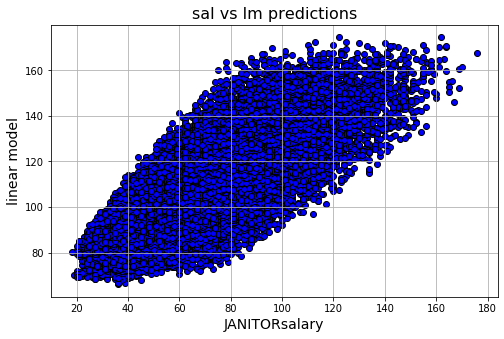

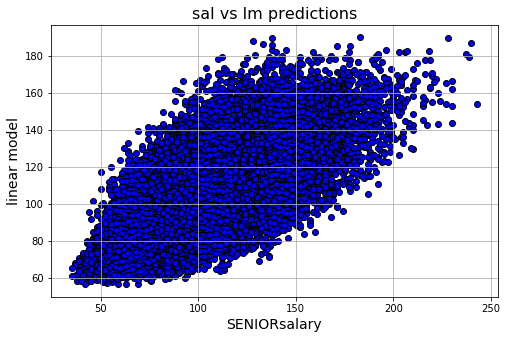

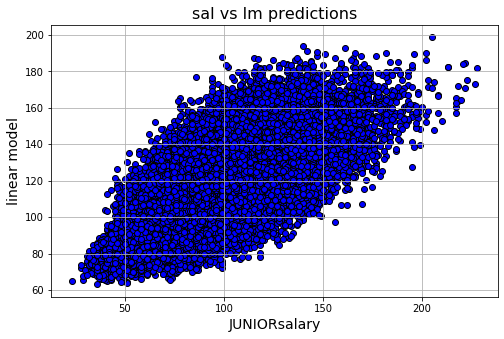

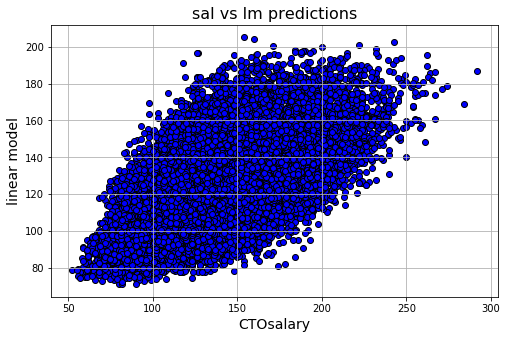

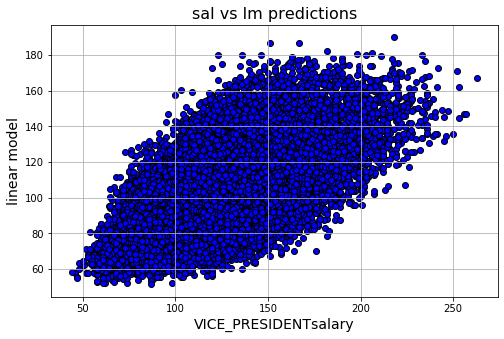

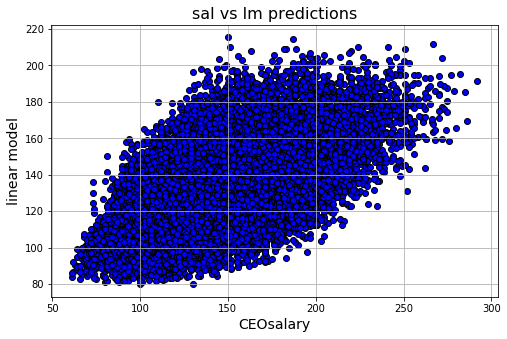

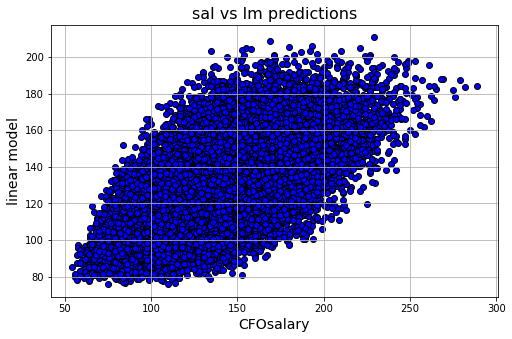

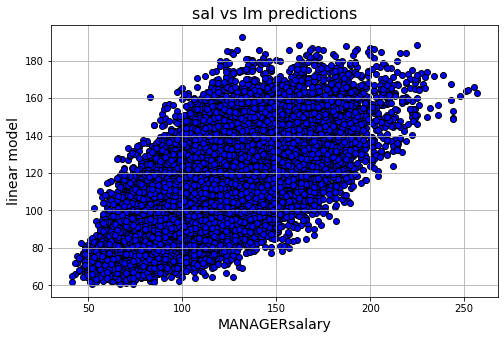

In [47]:
##review MVR model by the job type
  for c in test_fea.jobType.unique():
    ##lr_model1	xgb_model2	salary
    test_fea_sp = test_fea[test_fea['jobType'] == c ]
    plt.figure(figsize=(8,5))
    plt.title("sal vs lm predictions",fontsize=16)
    plt.scatter(x=test_fea_sp['salary'],y=test_fea_sp['lr_model1'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c+'salary',fontsize=14)
    plt.ylabel('linear model',fontsize=14)
    plt.show()

Heretroskedasticity is evident from the above graphs especially at higher salaries

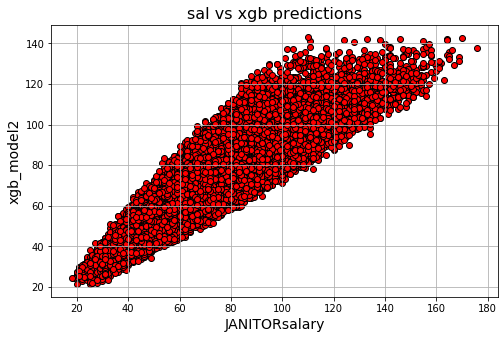

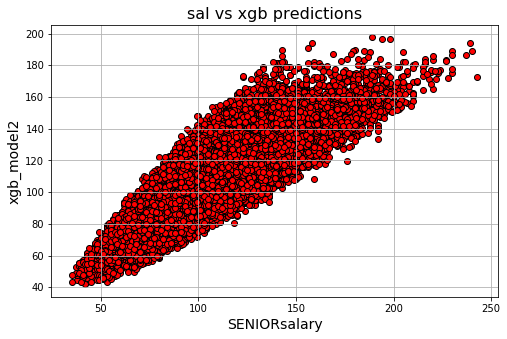

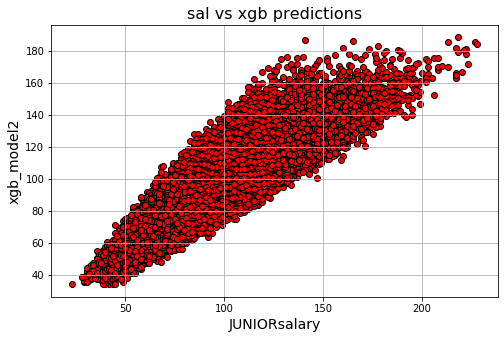

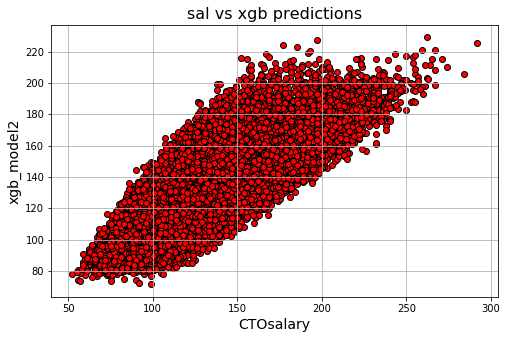

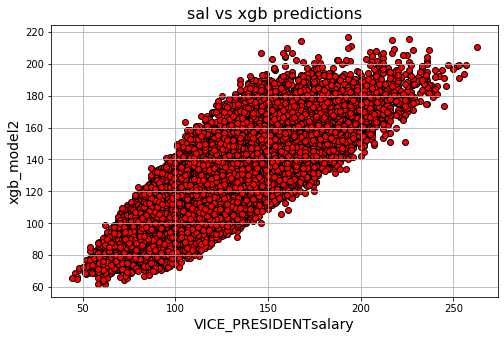

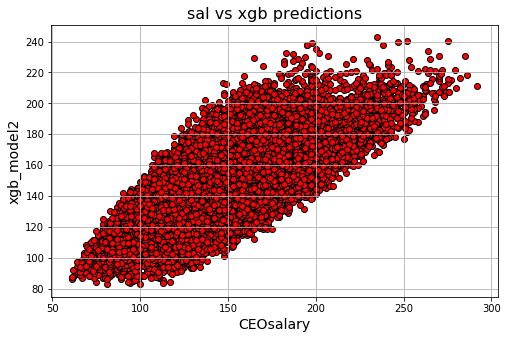

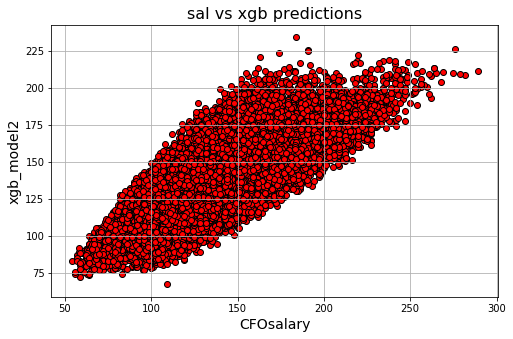

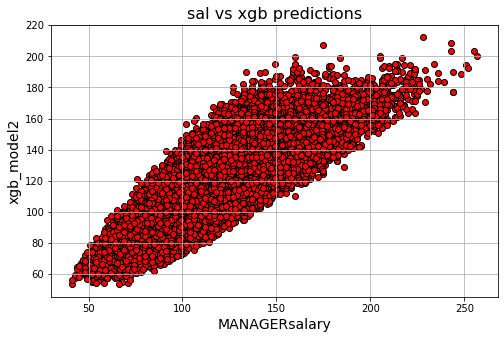

In [48]:
##review MVR model by the job type
 
  for c in test_fea.jobType.unique():
    ##lr_model1	xgb_model2	salary
    test_fea_sp = test_fea[test_fea['jobType'] == c ]
    plt.figure(figsize=(8,5))
    plt.title("sal vs xgb predictions",fontsize=16)
    plt.scatter(x=test_fea_sp['salary'],y=test_fea_sp['xgb_model2'],color='red',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c+'salary',fontsize=14)
    plt.ylabel('xgb_model2',fontsize=14)
    plt.show()

Heteroskedasticity seems to be less when we use XGboost model. However there still is some scope for improvement 

In [49]:
test_fea.head()

,Avg_Sal,degree,industry,int_yr_miles,jobType,major,milesFromMetropolis,yearsExperience,lr_model1,xgb_model2,salary
375364,166.0,NONE,HEALTH,105,JANITOR,NONE,5,21,149.317618,113.517296,100
169824,107.0,NONE,FINANCE,820,JANITOR,NONE,82,10,87.008598,69.432594,58
492908,100.0,BACHELORS,SERVICE,1640,SENIOR,ENGINEERING,82,20,121.220957,96.808090,77
749987,71.5,BACHELORS,SERVICE,2068,SENIOR,BUSINESS,94,22,126.370295,97.334854,128
717933,105.0,NONE,EDUCATION,180,SENIOR,NONE,90,2,60.794328,46.755768,46


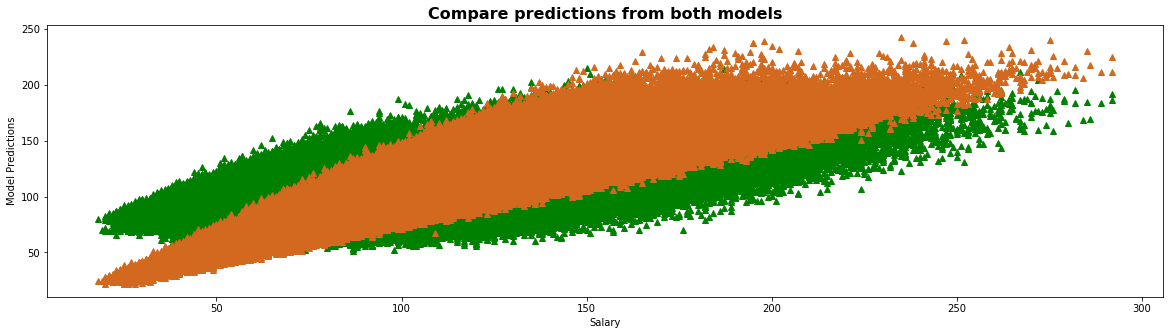

In [76]:
##compare salary in the test set with predictions from both models
test_fea_lt50 = test_fea.loc[test_fea['salary'] <= 5000]
test_fea_lt50.sort_values('salary')
plt.figure(figsize=(20,5))
plt.plot(test_fea_lt50['salary'], test_fea_lt50['lr_model1'],  '^', color="green")
plt.plot(test_fea_lt50['salary'], test_fea_lt50['xgb_model2'], '^', color="chocolate")
plt.title("Compare predictions from both models", fontsize=16, fontweight='bold')
plt.xlabel("Salary")
plt.ylabel("Model Predictions")
plt.show()

Conclusion : XGBOOST model can be deployed as baseline model. This model however needs some additional tuning